# ECI2017 Bayesian Models class Assignment

In this assignment, your task will be to implement and analyze Variational Bayesian (VB) inference for Gaussian Mixture Model (GMM) as described in the slides on [Approximate Inference in Bayesian Models](http://www.fit.vutbr.cz/~burget/BayesianModels/4-Approximate%20inference.pdf). The preferred and easiest way of accomplishing this task is to complete this Jupyter Notebook, which already comes with training data definition and a code for Maximum Likelihood (ML) training of a contrastive GMM system. If you do not have any experience with Jupyter Notebook, the easiest way to start is to install Anaconda2, run Jupyter Notebook and open the notebook downloaded from http://www.fit.vutbr.cz/~burget/BayesianModels/ECI2017_BayesianModels_Assignment.ipynb. You can also benefit from reusing pieces of code from the Jupyter Notebooks provided for this class, namely: [bayesian_inference_for_gaussian.ipynb](http://www.fit.vutbr.cz/~burget/BayesianModels/bayesian_inference_for_gaussian.ipynb) and [gs_gmm_training.ipynb](http://www.fit.vutbr.cz/~burget/BayesianModels/gs_gmm_training.ipynb).


The following cell contains a code with the definition of training data and the contrastive system training. You should no edit this part! The code does the following:

1. We "handcraft" a GMM (i.e. define GMM parameters) with 4 Gaussian components, which represents the "true distribution" of training data.
2. We have pre-generated training data from this GMM (see definition of variable x), so that everyone works with exactly the same data.
3. GMM with C=6 components is trained on the training data using ML training (the standard EM algorithm). You will use this GMM as a contrastive model. You will compare it to your implementation of VB GMM.
4. The following plots are made:
 * The true training data distribution (in grey).
 * The training observation generated from this true GMM (black + at the x axis).
 * The ML GMM estimate obtained using the EM algorithm (in black)

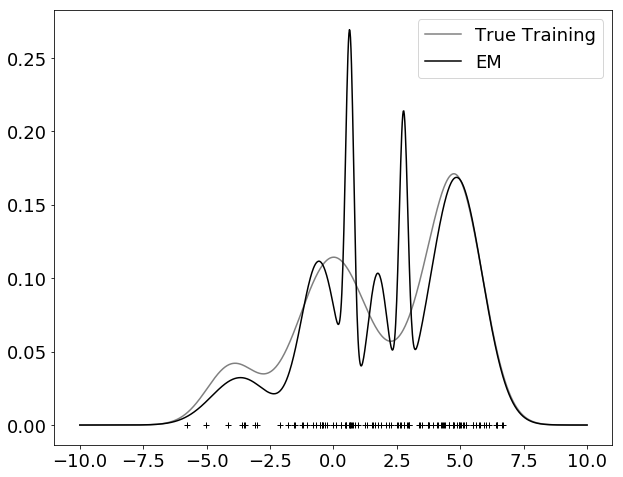

In [21]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.misc import logsumexp
from scipy.special import digamma
%matplotlib inline 
#%matplotlib qt5 #get an extra window for the plots
plt.rcParams.update({'figure.figsize': (10.0, 8.0), 'font.size': 18}) #Make the plots bigger


def GMM_pdf(x, mus, vars, pis):
    # Function for evaluating univariate GMM at values given by vector 'x'
    # 'mus', 'vars', 'pis' are vectors of means, variances and weights of individual Gaussian components
    # 'x[:,np.newaxis]' makes 'x' column vector to evaluate every coefficient of 'x' w.r.t. every Gaussian
    # component (row vectors 'mus' and 'vars') at once
    return sps.norm.pdf(x[:,np.newaxis], mus, np.sqrt(vars)).dot(pis) 

def GMM_rvs(N, mus, vars, pis):
    selector = sps.rv_discrete(values=(np.arange(len(pis)), pis)).rvs(size=N)
    sampled = sps.norm.rvs(loc=mus, scale=np.sqrt(vars), size=(N, len(pis)))
    return sampled[np.arange(len(selector)), selector]

# Parameters for generating training data
generate = False                   # If false, we use the pre-seeded data
mus_true = [-4.0, 0.0, 4.0, 5]    # Means
vars_true = [1.0, 1.96, 1.44, 1]  # Variances
pis_true = [0.1, 0.4, 0.2, 0.3]   # Categorical distribution probabilities
N = 1000                          # Number of samples to use
srange = np.linspace(-10,10, N)   # Range for sampling in the distribution

C = 6                             # Number of normal distributions to fit to the data
# Parameters of NormalGamma prior over means (mu) and precision (lambda)
m0, kappa0, a0, b0=[0.0, 0.05, 0.05, 0.05] 
#Parameters of Dirichlet prior weights
alpha0=1.0

if generate:
    x = GMM_rvs(N, mus_true, vars_true, pis_true)
    N = len(x)
else:
    x = np.array([ -3.07371088e+00, -4.14348725e+00, -3.01490821e+00, -3.54303388e+00, -3.48708234e+00, -3.59262207e+00,
     -5.76100178e+00, -5.02726789e+00, 8.28817153e-04, 4.99898450e-01, 2.83745605e-01, 6.71947042e-01,
     7.66679495e-01, 6.96995763e-01, 1.33546855e+00, 6.03847649e-01, -1.05992122e+00, 2.91024229e+00,
     -2.12682520e+00, 8.33533885e-01, 1.77147857e+00, 7.37629536e-01, -1.25040836e+00, 1.87318623e+00,
     -4.14582880e-01, 5.05680493e-01, 1.63091140e+00, 6.63219549e-01, -3.30841863e-01, -1.21874646e+00,
     2.64384057e+00, -4.32674840e-01, -1.79034947e+00, 3.13567565e-01, -5.43911715e-01, 2.28572951e+00,
     9.55653291e-01, -5.43582974e-01, -2.73850574e-01, -1.50383720e+00, 1.15925073e-01, 3.92541838e+00,
     -1.57267817e+00, 4.43581114e-01, -8.11856886e-01, 2.62442641e+00, -4.36298436e-01, -6.72286580e-01,
     1.52223784e+00, 1.25033658e+00, 4.88645989e+00, 2.96110183e+00, 4.74249957e+00, 2.17531545e+00,
     3.43072143e+00, 3.49315547e+00, 2.51223591e+00, 2.55369053e+00, 2.93122261e+00, 6.40247818e+00,
     5.12748233e+00, 4.08277439e+00, 4.96716209e+00, 1.56304959e+00, 4.31869585e+00, 2.07957592e+00,
     4.56265393e+00, 3.74342366e+00, 4.36177483e+00, 5.21824922e+00, 4.94100019e+00, 4.70062989e+00,
     6.12111884e+00, 6.69125720e+00, 5.03104495e+00, 5.72199065e+00, 4.29367941e+00, 3.72747772e+00,
     4.41461701e+00, 5.48741263e+00, 4.56782193e+00, 6.45701533e+00, 5.49118936e+00, 4.25947605e+00,
     3.39235348e+00, 4.10586407e+00, 2.76696554e+00, 6.66059909e+00, 6.00107916e+00, 5.92828295e+00,
     4.97460855e+00, 2.77746143e+00, 2.99416076e+00, 5.24459233e+00, 6.44720235e+00, 4.71084807e+00,
     5.62475093e+00, 3.76422931e+00, 5.79482964e+00, 5.11432194e+00])
    N = len(x)


mus_ml = x[:C]                    # We choose few first observations as the initial means
vars_ml = np.repeat(np.var(x), C) # Variances for all components are set to the global variance of the training data
pis_ml = np.ones(C)/C             # All component weights are set to the same value 1/C
# EM algorithm for ML GMM training
for _ in range(1000):
    #E-step
    log_p_xz = sps.norm.logpdf(x[:,np.newaxis], mus_ml, np.sqrt(vars_ml)) + np.log(pis_ml)
    log_p_x  = logsumexp(log_p_xz, axis=1, keepdims=True)
    gammas = np.exp(log_p_xz - log_p_x)
    
    #M-step
    Nc = gammas.sum(axis=0)
    mus_ml  =  x.dot(gammas) / Nc
    vars_ml =  (x**2).dot(gammas) / Nc - mus_ml**2
    pis_ml  = Nc / Nc.sum()

#4. Plot the true GMM, ML trained GMM and the observations
true_GMM_pdf = GMM_pdf(srange, mus_true, vars_true, pis_true)
ml_GMM_pdf  = GMM_pdf(srange, mus_ml, vars_ml, pis_ml)
plt.plot(srange, true_GMM_pdf, 'gray', label='True Training')
plt.plot(srange, ml_GMM_pdf, 'k', label='EM')
plt.plot(x, np.zeros_like(x), '+k')
plt.legend(loc='best')

# We copy the ML-learned gammas into gammas0 because gammas will be overwritten later
gammas0 = np.copy(gammas)

## Variational Bayes update formulae

$$
\DeclareMathOperator{\YY}{\boldsymbol{Y}}
\DeclareMathOperator{\ppi}{\boldsymbol{\pi}}
\DeclareMathOperator{\mmu}{\boldsymbol{\mu}}
\DeclareMathOperator{\llambda}{\boldsymbol{\lambda}}
\DeclareMathOperator{\aalpha}{\boldsymbol{\alpha}}
\DeclareMathOperator{\dts}{\mathinner{\ldotp\ldotp}}
$$

Here we summarize the VB update formulas which you need to implement:

* For all $c=1..C$, update parameters of $q(\mu_c, \lambda_c)^*=\mathrm{NormalGamma}\left(\mu_c,\lambda_c | m_c^*, \kappa_c^*, a_c^*, b_c^*, \right)$:
$$\begin{align*}
\\
m_c^* & = \frac{\kappa_0 m_0+N_c \bar{x}_c}{\kappa_0+N_c} & &N_c  = \sum_n \gamma_{nc} \\
\kappa_c^* &= \kappa_0+N_c                      & &\bar{x}_c =\frac{\sum_n \gamma_{nc}x_n}{\sum_n \gamma_{nc}}\\
a_c^* &= a_0+\frac{N_c}{2}                      & &s_c =\frac{\sum_n \gamma_{nc}(x_n-\bar{x}_c)^2}{\sum_n \gamma_{nc}}\\
b_c^* &= b_0+\frac{N_c}{2}\left(s_c+\frac{\kappa_0 (\bar{x}_c-m_0)^2}{\kappa_0+N_c}\right)\\
\\
\end{align*}$$
where $\gamma_{nc}$ are the responsibilities defined below in the update of $q(z_n)^*$. For the first VB iteration, use the responsibilities from the last iteration of the EM algorithm above (i.e. use the current setting of the variable 'gammas')

* Update parameters of $q(\boldsymbol{\pi})^*=\mathrm{Dir}(\ppi|\aalpha^*)$:
$$\begin{align*}
\\
& \aalpha^*=[\alpha_1^*, \alpha_2^*, \dots, \alpha_C^*] \\
& \alpha_c^*=\alpha_0+N_c\\
\\
\end{align*}$$

* For all $n=1..N$, update distributions $q(z_n)^*$, which are the approximate posterior probabilities for assigning  observations to Gaussian components (i.e. the responsibilities $\gamma_{nc}$):
$$\begin{align*}
\\
& \rho_{nc} = \exp\left(\psi(\alpha_c^*)-\psi\left(\sum_c\alpha_c^*\right)+\frac{\psi(a_c^*)-\ln b_c^*}{2}-\frac{1}{2\kappa_c^*}-\frac{a_c^*}{2b_c^*}(x_n-m_c^*)^2\right)\\
& \gamma_{nc}=\frac{\rho_{nc}}{\sum_k \rho_nc}\\
\\
\end{align*}$$
where $\psi(a)$ is digamma function (e.g. scipy.special.digamma)

* Iterate until the convergence (i.e. until there is not significant change when updating the parameters. Alternatively, you can try to derive and implement evaluation of the evidence lower bound function $\mathcal{L}(q(\YY))$ and use it to monitor the convergence).

In the equations abowe, parameters $m_0, \kappa_0, a_0, b_0$ are the parameters of the NormalGamma priors $p(\mu_c, \lambda_c)$. The same prior is used for all Gaussian components $c \in \{1\dts C\}$. Parameter $\alpha_0$ is the parameters of the Dirichlet prior distribution of the component weights $p(\ppi)$. Note that Dirichlet distribution is, in general, parametrized by vector $\aalpha_0$. However, we set all its coefficients to the same value. Therefore only single scalar parameter $\alpha_0$.

For your VB-GMM implementation, use the following setting of the prior parameters! 

Now, code the update formulas for the VB approximation.

* Use the responsibilities (variable 'gammas') obtained from the ML training (EM algorithm implemented above) to initialize the assignments of observations to Gaussian components. This implies that we use the same number of Gaussian components $C=6$ as for the ML training.

* Run iteratively the updates until the algorithm converges.

Once the VB model is trained:

* Plot the estimated approximate distributions $q(\mu_c,\lambda_c)$ for all the Gaussian components $c \in \{1\dts C\}$. You can reuse the code for plotting NormalGamma distribution from [bayesian_inference_for_gaussian.ipynb](http://www.fit.vutbr.cz/~burget/BayesianModels/bayesian_inference_for_gaussian.ipynb) notebook.

* Print also the vector of parameters $\aalpha^*$ of the approximate posterior distribution of the weights $q(\ppi)$.

* Analyze these results. What can you say about the obtained posteriors distributions? What do they represent? How do these posterior distribution compare to the parameter estimates obtained from the EM algorithm?

* Generate several (say 50) samples from the approximate posterior distribution $q(\ppi,\mmu,\llambda)^* = q(\ppi)^* \prod_{c=1}^C q(\mu_c,\lambda_c)^*$. Each such sample is set of parameters of one GMM. Plot the GMM distributions corresponding to all the samples into a single figure. Comment on this plot. What do the individual GMM distributions represent?

* Now, average all the GMM distributions from the previous step. Attention! Average the GMM distributions, not their parameters as sampled from $q(\ppi,\mmu,\llambda)^*$. What can you say about the obtained average distribution? What does it represent? Hint: We do similar averaging of GMMs in [gs_gmm_training.ipynb](http://www.fit.vutbr.cz/~burget/BayesianModels/gs_gmm_training.ipynb).


In [22]:
from scipy.special import digamma

def update_params(m0, kappa0, a0, b0, alpha0, c, x, gammas):
    gammas_class = gammas[:,c]
    (x_c_avg, n_c) = np.average(x, weights=gammas_class, returned=True, axis=0)
    s_c = np.average(np.square(x - x_c_avg), weights=gammas_class)
    
    m_c_star = (kappa0 * m0 + n_c * x_c_avg) / (kappa0 + n_c)
    kappa_c_star = kappa0 + n_c
    a_c_star = a0 + (n_c / 2.0)
    b_c_star = b0 + ((n_c / 2.0) * (s_c + ((kappa0 * np.square(x_c_avg - m0))/(kappa0 + n_c))))
    
    alpha_c_star = alpha0 + n_c
    return (m_c_star, kappa_c_star, a_c_star, b_c_star, alpha_c_star)

def train(m0, kappa0, a0, b0, alpha0, gammas0, x, epsilon):
    rhos = np.zeros(shape=(N, C))
    m = np.zeros(shape=(C,))
    kappa = np.zeros(shape=(C,))
    a = np.zeros(shape=(C,))
    b = np.zeros(shape=(C,))
    alpha = np.zeros(shape=(C,))
    gammas = gammas0

    for iteration in range(10000):
        previous = np.copy([m, kappa, a, b, alpha])
        for c in range(C):
            (m[c], kappa[c], a[c], b[c], alpha[c]) = update_params(m0, kappa0, a0, b0, alpha0, c, x, gammas)
            
        for c in range(C):
            # The first 4 terms of the rho update don't depend on n, so we can precompute them
            t1 = digamma(alpha[c])
            t2 = digamma(np.sum(alpha))
            t3 = (digamma(a[c]) - np.log(b[c])) / 2.0
            t4 = 1.0 / 2.0 * kappa[c]
            tpart = t1 - t2 + t3 - t4
            ppart = a[c] / 2.0 * b[c]

            # Update the responsabilities of this class to the training data
            for n in range(N):
                # This could be done in batch by numpy, but avoiding it because this seems more explicit
                t5 = ppart * np.square(x[n] - m[c])
                rhos[n][c] = np.exp(tpart - t5)

        for c in range(C):
            gammas[n] = rhos[n] / np.sum(rhos[n])
            
        current = np.copy([m, kappa, a, b, alpha])
        delta = np.linalg.norm(previous - current, ord=2)
        if delta < epsilon:
            break

    return m, kappa, a, b, alpha, gammas

m, kappa, a, b, alpha, gammas = train(m0, kappa0, a0, b0, alpha0, gammas0, x, 0.00000001)

Approximate posterior distribution of weights (q): [ 0.09530115  0.0962085   0.40421586  0.10629599  0.19582768  0.10215082]


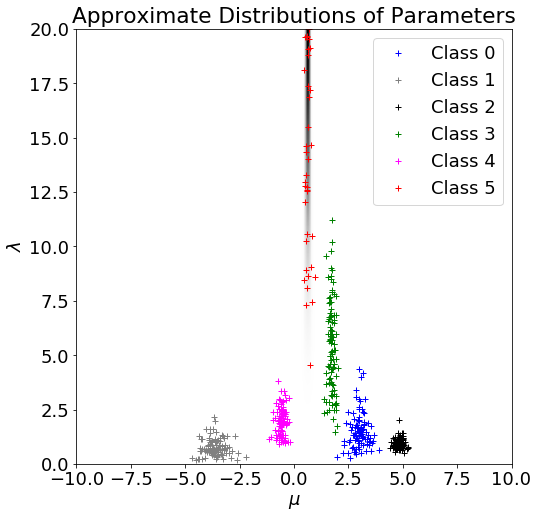

In [27]:
def plot_parameter_distributions(C, alpha, m, kappa, a, b, plot_limits, colors):
    def NormalGamma_plot(m0, kappa0, a0, b0, limits, color, label):
        mu_vals, lmbd_vals = np.meshgrid(np.linspace(limits[0], limits[1], 500), np.linspace(limits[2], limits[3], 500))
        pdf = NormalGamma_pdf(mu_vals, lmbd_vals, m0, kappa0, a0, b0)

        mu_sampled, lmbd_sampled = NormalGamma_rvs(m0, kappa0, a0, b0, 100)
        plt.plot(mu_sampled, lmbd_sampled, '+', color=color, label=label);
        plt.imshow(pdf, origin='lower', cmap='Greys', extent=limits)
        plt.xlabel('$\mu$'); plt.ylabel('$\lambda$')
        
    print('Approximate posterior distribution of weights (q):', alpha/np.sum(alpha))
    plt.figure()
    plt.title('Approximate Distributions of Parameters')
    for c in range(C):
        NormalGamma_plot(m[c], kappa[c], a[c], b[c], plot_limits, colors[c], 'Class ' + str(c))
    plt.legend(loc='best')
    
plot_parameter_distributions(C, alpha, m, kappa, a, b,
                             plot_limits=[-10, 10, 0.01, 20],
                             colors=['blue', 'grey', 'black', 'green', 'magenta', 'red'])

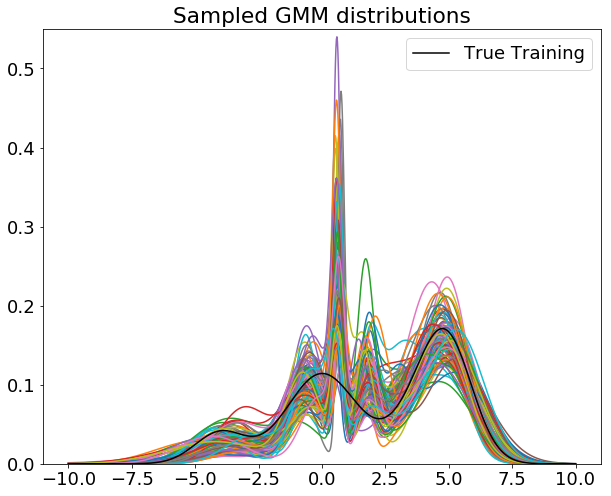

In [23]:
def NormalGamma_pdf(mu, lmbd, m, kappa, a, b):
    # sps.norm.pdf takes mean and std (not variance), therefore 1.0/
    # sps.gamma.pdf takes shape and scale (not rate), therefore 1.0/b
    return sps.norm.pdf(mu, m, 1.0/np.sqrt(lmbd*kappa)) * sps.gamma.pdf(lmbd, a, scale=1.0/b)

def NormalGamma_rvs(m, kappa, a, b, N):
    # Sample from NormalGamma distribution
    lmbd = sps.gamma.rvs(a, scale=1.0/b, size=N)
    mu = sps.norm.rvs(m, 1.0/np.sqrt(lmbd*kappa), N)
    return mu, lmbd

def q_rvs(N, C, alpha, m, kappa, a, b):
    pis = sps.dirichlet.rvs(alpha, N)
    
    mus = np.zeros(shape=(C, N))
    lambdas = np.zeros(shape=(C, N))
    for c in range(C):
        mus[c], lambdas[c] = NormalGamma_rvs(m[c], kappa[c], a[c], b[c], N)
    mus = mus.T
    lambdas = lambdas.T
    return pis, mus, lambdas

def plot_gmm_samples(num_gmm_samples, true_GMM_pdf, t, C, alpha, m, kappa, a, b):
    pis, mus, lambdas = q_rvs(num_gmm_samples, C, alpha, m, kappa, a, b)
    lambdas = 1.0/lambdas
    
    plt.figure()
    plt.title('Sampled GMM distributions')
    for i in range(num_gmm_samples):
        sampled_GMM_pdf = GMM_pdf(t, mus[i], lambdas[i], pis[i])
        plt.plot(t, sampled_GMM_pdf)
    plt.plot(t, true_GMM_pdf, color='black', label='True Training')
    plt.legend(loc='best')
    plt.ylim((0.0, .55))

plot_gmm_samples(100, true_GMM_pdf, srange, C, alpha, m, kappa, a, b)

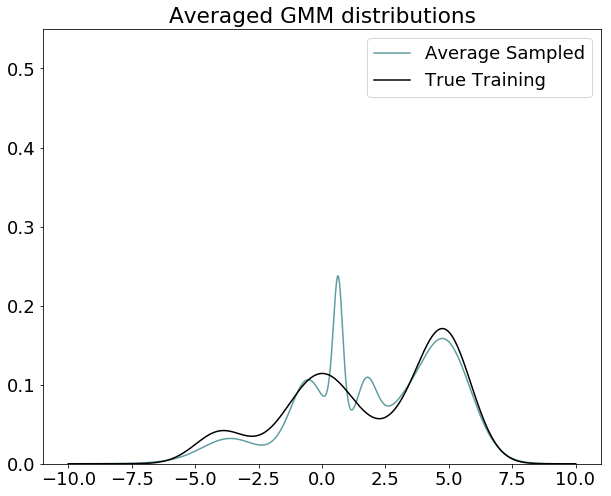

In [28]:
def plot_avg_gmm_samples(num_gmm_samples, true_GMM_pdf, t, C, alpha, m, kappa, a, b):
    pis, mus, lambdas = q_rvs(num_gmm_samples, C, alpha, m, kappa, a, b)
    lambdas = 1.0/lambdas
    
    plt.figure()
    plt.title('Averaged GMM distributions')
    for i in range(num_gmm_samples):
        current_GMM_pdf = GMM_pdf(t, mus[i], lambdas[i], pis[i])
        if i == 0:
            sampled_GMM_pdf = current_GMM_pdf
        else:
            sampled_GMM_pdf += current_GMM_pdf
    sampled_GMM_pdf /= float(num_gmm_samples)
    plt.plot(t, sampled_GMM_pdf, color='cadetblue', label='Average Sampled')
    plt.plot(t, true_GMM_pdf, color='black', label='True Training')
    plt.legend(loc='best')
    plt.ylim((0.0, .55))
    return sampled_GMM_pdf

sampled_GMM_pdf = plot_avg_gmm_samples(100, true_GMM_pdf, srange, C, alpha, m, kappa, a, b)

Now estimate and plot the posterior predictive distribution using the following formula (Note that similar distribution is evaluated in each iteration of Collapsed Gibbs Sampling in [gs_gmm_training.ipynb](http://www.fit.vutbr.cz/~burget/BayesianModels/gs_gmm_training.ipynb)):

$$\begin{align*}
\\
& p(x')=\sum_c St\left(x'|m_c^*,2a_c^*,\frac{a_c^* \kappa_c^*}{b_c^*(\kappa_c^*+1)}\right)\frac{\alpha_c^*}{\sum_c \alpha_c^*}\\
\\
\end{align*}$$
How does the resulting posterior predictive distribution compare to:
- the true training data distribution
- the GMM obtained using ML training (i.e. using EM algorithm)
- the average of GMM distributions obtained in the previous step by sampling from $q(\ppi,\mmu,\llambda)^*$

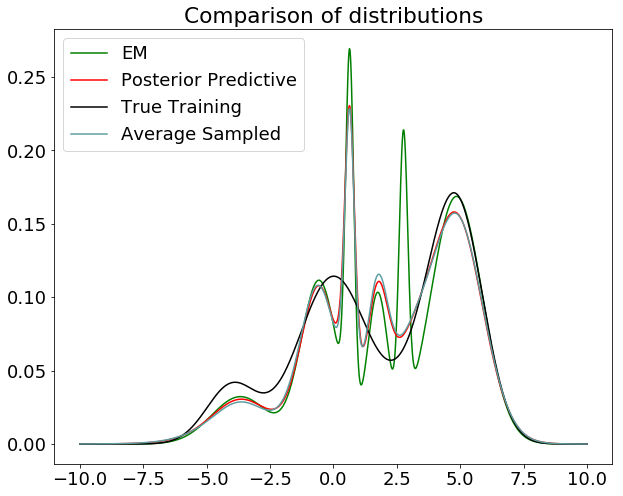

In [26]:
def plot_posterior(limits):
    posterior = 0
    for c in range(C):
        weight = alpha[c] / np.sum(alpha)
        posterior += sps.t.pdf(limits, loc=m[c], df=2*a[c], scale=np.sqrt((b[c] * (kappa[c] + 1))/(a[c]*kappa[c]))) * weight
        
    plt.figure()
    plt.title('Comparison of distributions')
    plt.plot(limits, ml_GMM_pdf, color='green', label='EM')
    plt.plot(limits, posterior, color='red', label='Posterior Predictive')
    plt.plot(limits, true_GMM_pdf, color='black', label='True Training')
    plt.plot(limits, sampled_GMM_pdf, color='cadetblue', label='Average Sampled')
    plt.legend(loc='best')
    return posterior

_ = plot_posterior(srange)

Generate larger number of training observations (e.g. 1000 samples) from the true distribution (mus_true, vars_true, pis_true) and repeat the whole experiment once more with the larger amount of training data. Regenerate all the plots and comment on how they change from the previous experiments with smaller training data set.

Try to implement as much as you can and answer ans many questions as you can. It is fine if you do not understand some questions or if you do not know some of the answers.